In [3]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp
import datetime

import matplotlib.pylab as plt
import os
import random
import math

In [4]:
def return_calc(data_set,l):    # Function to calculate returns and convert it to dataframe
    
    return_A=[]
    return_B=[]

    for r in range(0,l-1):
        ret_A=np.log(data_set[0][r+1]/data_set[0][0])
        ret_B=np.log(data_set[1][r+1]/data_set[1][0])
        return_A.append(ret_A)
        return_B.append(ret_B)

    return pd.DataFrame (list(zip(return_A,return_B)),columns=['A','B'])

In [9]:
#S0_A=data[0][-1]
#S0_B=data[1][-1]
#S0_C=data[2][-1]
#S0_D=data[3][-1]

def Rho_matrix(RhoAB):            #Correlelation matrix
    corr=np.array([[1.0,RhoAB],
                  [RhoAB,1.0]])
    return corr

#correlation=Rho_matrix(0.8)

def MC(ER_A,ER_B,S0_A,S0_B,sigma_A,sigma_B,RhoAB,intervals,sim): # Monte Carlo Simulation of daily paths of stock A & stock B using GBM equation
    
    scenario_A = []  # storing simulate prices of stock A
    scenario_B = []  # storing simulate prices of stock B

    std=np.diag([sigma_A, sigma_B])  #volatility matrix of stock A and stock B
    corr_matrix=Rho_matrix(RhoAB)    #correlation matrix of stock A & stock B
    cov_matrix=np.dot(std,np.dot(std,corr_matrix))      # covariance matrix 
    L = np.linalg.cholesky(np.array(cov_matrix)) # Cholesky decomposition of cov matrix to get bivariate normal distribution
    T=1.0 
    
    for i in range(sim):
        sp.random.seed(12345+i)
        V = L.dot(np.random.normal(0, 1, 2))
        
        ST_A=S0_A*np.exp((ER_A-(sigma_A**2)/2)*(T/intervals)+sigma_A*V[0]*np.sqrt(T/intervals))
        ST_B=S0_B*np.exp((ER_B-(sigma_B**2)/2)*(T/intervals)+sigma_B*V[1]*np.sqrt(T/intervals))
        scenario_A.append(ST_A)
        scenario_B.append(ST_B)
        S0_A=ST_A
        S0_B=ST_B
       
    return [scenario_A,scenario_B]


In [19]:
#correlation=Rho_matrix(0.8)
MC(0.14,0.18,100,110,0.25,0.3,-0.1,252,100) # 100 simulation runs for two stocks A & B

[[99.96256570503803,
  99.97029069256403,
  100.14886571621727,
  100.71001022052394,
  100.41623304651618,
  100.75466980784093,
  100.18998488621324,
  100.49183829171726,
  100.783148734615,
  100.44269561113767,
  99.5900603039023,
  99.90299911062466,
  100.17471006716346,
  100.52066899816317,
  100.18854668858802,
  100.59784586702455,
  100.46945228513249,
  100.95746333329656,
  101.17483104127412,
  101.43069838605555,
  101.31020302331464,
  101.77462708424238,
  101.49782706850037,
  101.61065982767309,
  101.78553889557598,
  102.51375315505999,
  102.38841249912072,
  102.95854126063826,
  103.87944681058765,
  104.12230638834723,
  103.89329827988156,
  103.93740221539146,
  104.00812707791847,
  104.08037840850406,
  104.10417037551443,
  103.30765320819373,
  103.88723843206853,
  104.4096309685107,
  105.07813107108124,
  105.36215649714518,
  105.33102347052515,
  105.0576633821779,
  105.63934161473937,
  105.04008087806395,
  105.91827438371173,
  106.3939682326155

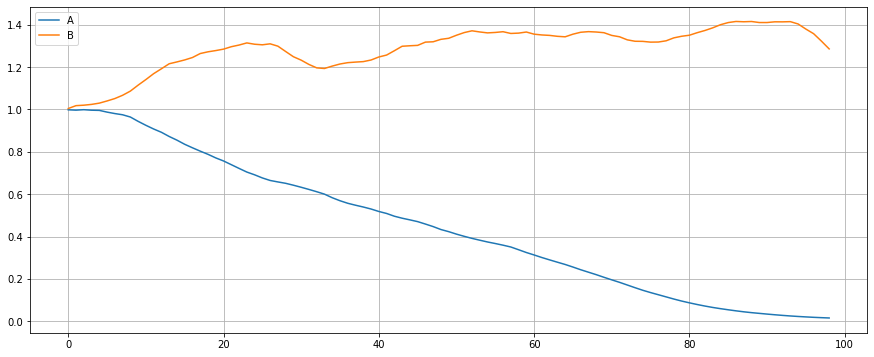

In [28]:
cr=(1+return_calc(MC(-0.3,0.18,100,110,0.25,0.3,-0.4,252,100),100)).cumprod()
plt.rcParams["figure.figsize"] = (15,6)
cr.plot(grid=True)
plt.show()

In [29]:
port=return_calc(MC(-0.3,0.18,100,110,0.25,0.3,-0.4,252,100),100)
w1,w2=0.5,0.5  #portfolio with equal weights 
port['returns']=port['A']*w1+port['B']*w2
port

A         B   returns
0  -0.001669  0.004557  0.001444
1  -0.001630  0.013351  0.005861
2   0.002211  0.002128  0.002170
3  -0.002456  0.003696  0.000620
4  -0.000837  0.005791  0.002477
..       ...       ...       ...
94 -0.095764 -0.007774 -0.051769
95 -0.093069 -0.017114 -0.055092
96 -0.094762 -0.015880 -0.055321
97 -0.087543 -0.025708 -0.056625
98 -0.087018 -0.027884 -0.057451

[99 rows x 3 columns]

In [30]:
port.sort_values(['returns'],inplace=True,ascending=True)
port

A         B   returns
98 -0.087018 -0.027884 -0.057451
97 -0.087543 -0.025708 -0.056625
96 -0.094762 -0.015880 -0.055321
95 -0.093069 -0.017114 -0.055092
94 -0.095764 -0.007774 -0.051769
..       ...       ...       ...
4  -0.000837  0.005791  0.002477
11 -0.018832  0.024404  0.002786
8  -0.010923  0.018519  0.003798
7  -0.005793  0.014704  0.004456
1  -0.001630  0.013351  0.005861

[99 rows x 3 columns]

In [34]:
VaR95=port['returns'].quantile(0.05)
VaR99=port['returns'].quantile(0.01)
print ('VaR95: {:.2%}' .format(VaR95)) #Value at Risk at 95% confidence interval for single day returns
print ('VaR99: {:.2%}' .format(VaR99))

VaR95: -4.89%
VaR99: -5.66%
